**Imports**

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Configuration

In [1]:
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
OUTPUT_PATH = "3b.csv"

CLIP_FLOOR = 1.0
FREQ_THRESHOLD = 0.01
RANDOM_STATE = 42
N_SPLITS_CV = 3
VERBOSE = True


def get_feature_names_from_coltransformer(ct, numeric_cols, categorical_cols):

    feature_names = []
    try:

        num_names = ct.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numeric_cols)
        # But robustscaler may not have that; fallback to numeric_cols
        if len(num_names) != len(numeric_cols):
            num_names = numeric_cols
    except Exception:
        num_names = numeric_cols

    # categorical onehot names
    try:
        ohe = ct.named_transformers_['cat'].named_steps['onehot']
        cat_ohe_names = list(ohe.get_feature_names_out(categorical_cols))
    except Exception:
        # emergencuy usage
        cat_ohe_names = categorical_cols


    remainder_names = []
    if ct.remainder == 'passthrough':

        pass

    feature_names = list(num_names) + list(cat_ohe_names) + remainder_names
    return feature_names

Loading Data

In [4]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

test_ids = test_df['Hospital_Id'].copy()
train_df.set_index('Hospital_Id', inplace=True)
test_df.set_index('Hospital_Id', inplace=True)

y_train = train_df["Transport_Cost"].copy()
X_train = train_df.drop(columns=["Transport_Cost"]).copy()
X_test = test_df.copy()

Transform the target to stabilize variance and reduce skew using log1p (log(1 + x)). Also ensures no log of values < 1 by clipping to CLIP_FLOOR

In [5]:
y_train_transformed = np.log1p(y_train.clip(lower=CLIP_FLOOR))
print(f"   Transformed (log1p) range: [{y_train_transformed.min():.4f}, {y_train_transformed.max():.4f}]")

   Transformed (log1p) range: [0.6931, 16.2264]


Exploratory Data Analysis

In [63]:
train_df.head()

,Supplier_Name,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,Transport_Method,Fragile_Equipment,Hospital_Info,Rural_Hospital,Order_Placed_Date,Delivery_Date,Hospital_Location,Transport_Cost
Hospital_Id,,,,,,,,,,,,,,,,,,,
fffe3200360030003700,Jo Valencia,0.44,21.0,6.0,NaN,NaN,3.62,17.13,No,No,No,Roadways,No,Working Class,No,10/20/17,10/20/17,APO AA 33776,179.50
fffe3400380037003400,Wanda Warren,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,No,Yes,Yes,Roadways,No,Working Class,No,02/22/16,02/24/16,"South Kevin, VT 84493",627732.45
fffe3200350036003700,Robert Ackies,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,No,No,No,Roadways,No,Working Class,No,01/11/18,01/10/18,"Kevinshire, NE 31279",1565.92
fffe3800320034003400,Charlotte Membreno,0.70,8.0,5.0,606.0,Brass,4.55,17.48,No,No,No,Roadways,No,Working Class,No,08/06/16,08/06/16,DPO AP 61572,257.71
fffe3600340033003000,Nena Silva,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,Yes,No,No,Roadways,No,Working Class,NaN,12/15/16,12/17/16,"Joshuamouth, AK 01550",8553.52


In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, fffe3200360030003700 to fffe3100300038003300
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Supplier_Name         5000 non-null   object 
 1   Supplier_Reliability  4413 non-null   float64
 2   Equipment_Height      4717 non-null   float64
 3   Equipment_Width       4557 non-null   float64
 4   Equipment_Weight      4540 non-null   float64
 5   Equipment_Type        4401 non-null   object 
 6   Equipment_Value       5000 non-null   float64
 7   Base_Transport_Fee    5000 non-null   float64
 8   CrossBorder_Shipping  5000 non-null   object 
 9   Urgent_Shipping       5000 non-null   object 
 10  Installation_Service  5000 non-null   object 
 11  Transport_Method      3929 non-null   object 
 12  Fragile_Equipment     5000 non-null   object 
 13  Hospital_Info         5000 non-null   object 
 14  Rural_Hospital        4414 non-null   obje

In [65]:
float_list = ['Supplier_Reliability', 'Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Equipment_Value', 'Base_Transport_Fee','Transport_Cost']

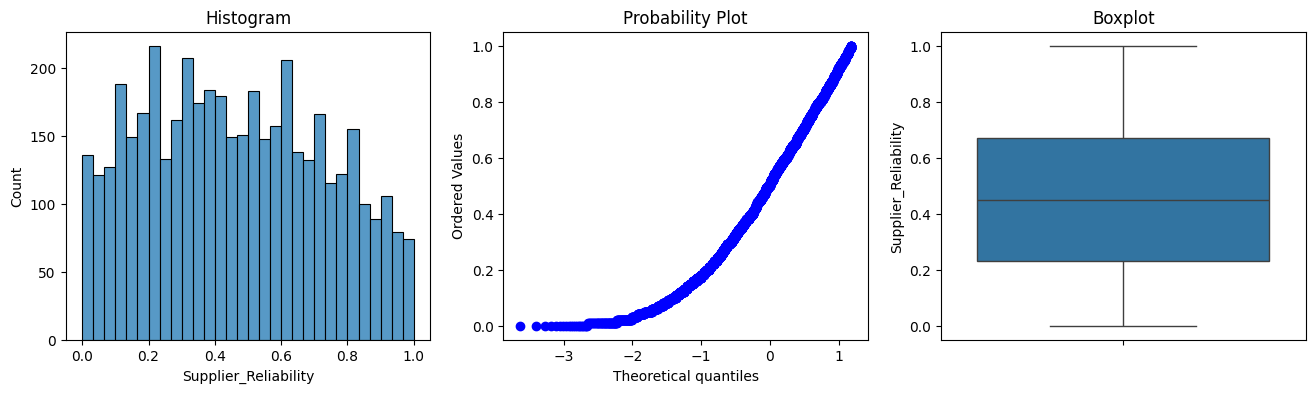

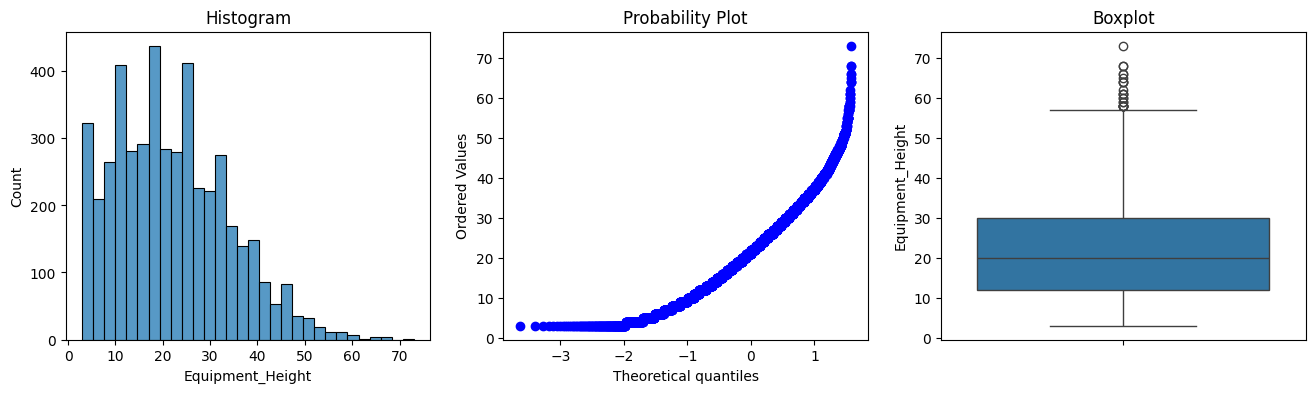

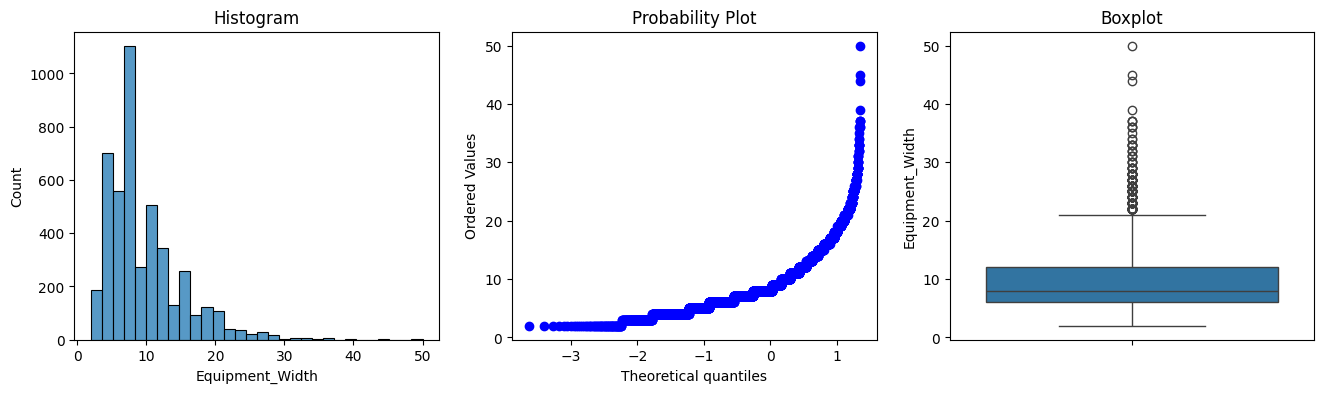

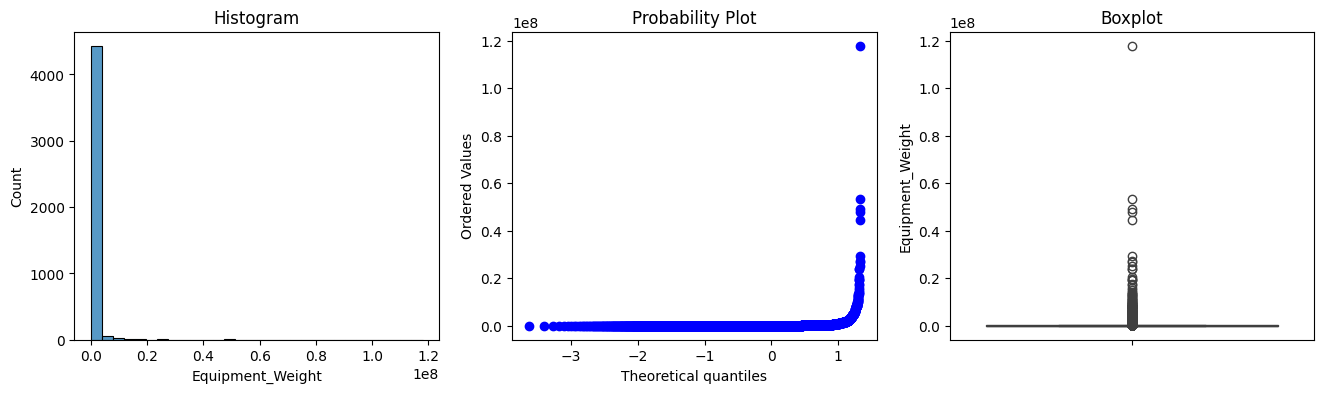

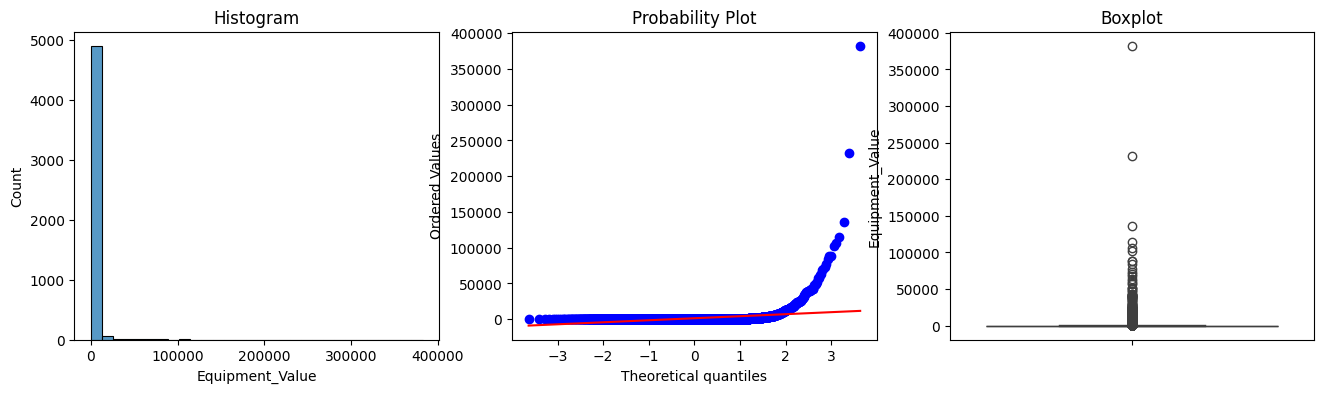

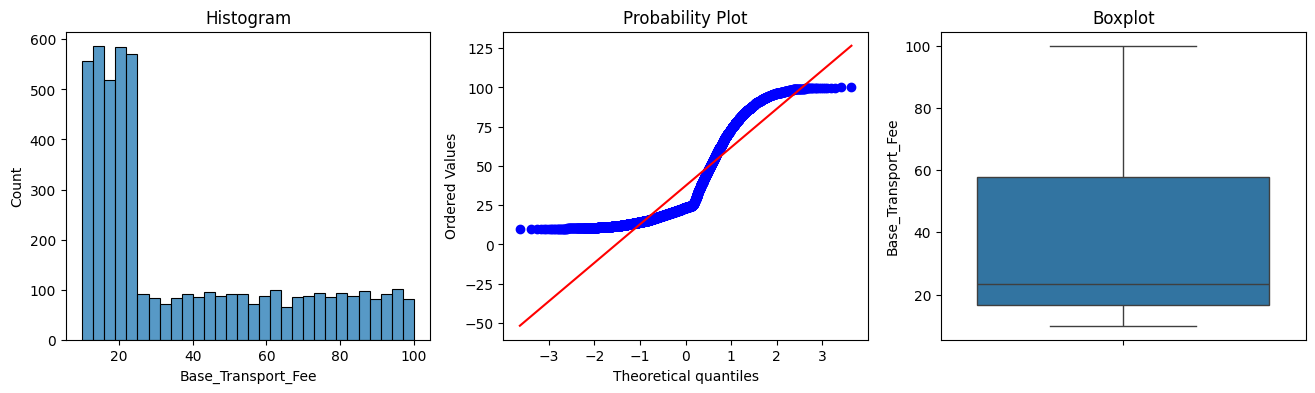

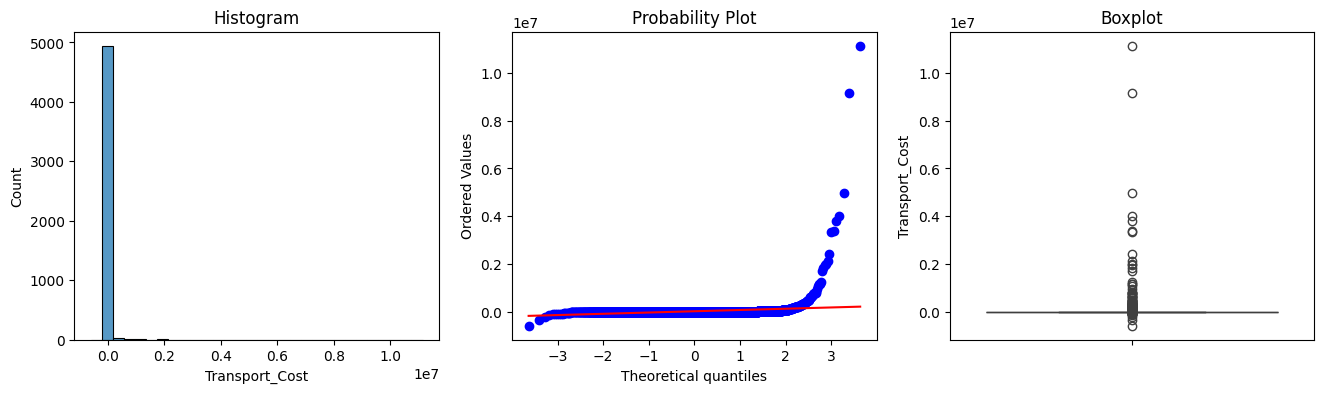

In [68]:
for col in float_list:

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(train_df[col], bins = 30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(train_df[col], dist = "norm", plot = plt)
    plt.title('Probability Plot')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y = train_df[col])
    plt.title('Boxplot')

    plt.show()

In [69]:
train_df['Transport_Cost'].unique()

array([1.7950000e+02, 6.2773245e+05, 1.5659200e+03, ..., 5.1654500e+03,
       1.2415000e+02, 3.7328000e+02])

In [71]:
train_df['Transport_Cost']=train_df['Transport_Cost'].abs()
train_df['Transport_Cost']=np.log(train_df['Transport_Cost'])

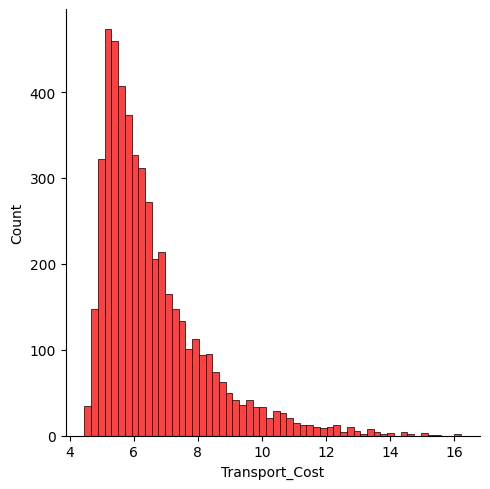

In [72]:
sns.displot(train_df['Transport_Cost'], kde = False, color ='red')

In [74]:
for col in float_list:
    print(f'{col}: {train_df[col].skew(skipna=True)}')

Supplier_Reliability: 0.14428848753164428
Equipment_Height: 0.5800251831932504
Equipment_Width: 1.5950530144963881
Equipment_Weight: 22.595815822232087
Equipment_Value: 1.340338028696922
Base_Transport_Fee: 0.9209600684462876
Transport_Cost: 1.741289645407552


In [73]:
train_df['Equipment_Value'] = np.log(train_df ['Equipment_Value'])
train_df.head(5)

,Supplier_Name,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,Transport_Method,Fragile_Equipment,Hospital_Info,Rural_Hospital,Order_Placed_Date,Delivery_Date,Hospital_Location,Transport_Cost
Hospital_Id,,,,,,,,,,,,,,,,,,,
fffe3200360030003700,Jo Valencia,0.44,21.0,6.0,NaN,NaN,1.286474,17.13,No,No,No,Roadways,No,Working Class,No,10/20/17,10/20/17,APO AA 33776,5.190175
fffe3400380037003400,Wanda Warren,0.58,29.0,20.0,1210684.0,Marble,9.180229,35.42,No,Yes,Yes,Roadways,No,Working Class,No,02/22/16,02/24/16,"South Kevin, VT 84493",13.349869
fffe3200350036003700,Robert Ackies,0.97,39.0,15.0,3305.0,Aluminium,3.694116,18.54,No,No,No,Roadways,No,Working Class,No,01/11/18,01/10/18,"Kevinshire, NE 31279",7.356229
fffe3800320034003400,Charlotte Membreno,0.70,8.0,5.0,606.0,Brass,1.515127,17.48,No,No,No,Roadways,No,Working Class,No,08/06/16,08/06/16,DPO AP 61572,5.551835
fffe3600340033003000,Nena Silva,0.66,27.0,13.0,NaN,Marble,7.910884,30.23,Yes,No,No,Roadways,No,Working Class,NaN,12/15/16,12/17/16,"Joshuamouth, AK 01550",9.054098


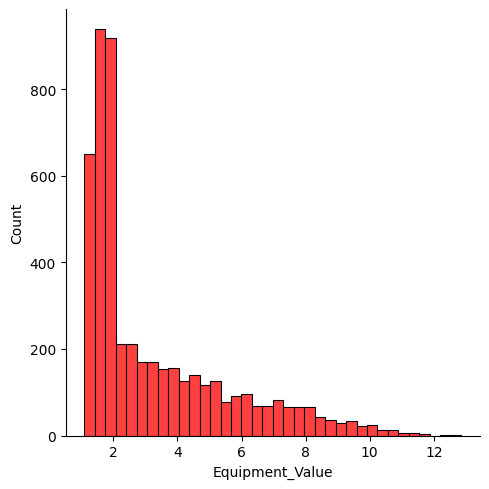

In [75]:
sns.displot(train_df['Equipment_Value'], kde = False, color ='red')

In [76]:
train_df['Order_Placed_Date'] = pd.to_datetime(train_df['Order_Placed_Date'],format='%m/%d/%y')
train_df['Delivery_Date'] =  pd.to_datetime(train_df['Delivery_Date'],format='%m/%d/%y')
train_df.head(5)

,Supplier_Name,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,Transport_Method,Fragile_Equipment,Hospital_Info,Rural_Hospital,Order_Placed_Date,Delivery_Date,Hospital_Location,Transport_Cost
Hospital_Id,,,,,,,,,,,,,,,,,,,
fffe3200360030003700,Jo Valencia,0.44,21.0,6.0,NaN,NaN,1.286474,17.13,No,No,No,Roadways,No,Working Class,No,2017-10-20,2017-10-20,APO AA 33776,5.190175
fffe3400380037003400,Wanda Warren,0.58,29.0,20.0,1210684.0,Marble,9.180229,35.42,No,Yes,Yes,Roadways,No,Working Class,No,2016-02-22,2016-02-24,"South Kevin, VT 84493",13.349869
fffe3200350036003700,Robert Ackies,0.97,39.0,15.0,3305.0,Aluminium,3.694116,18.54,No,No,No,Roadways,No,Working Class,No,2018-01-11,2018-01-10,"Kevinshire, NE 31279",7.356229
fffe3800320034003400,Charlotte Membreno,0.70,8.0,5.0,606.0,Brass,1.515127,17.48,No,No,No,Roadways,No,Working Class,No,2016-08-06,2016-08-06,DPO AP 61572,5.551835
fffe3600340033003000,Nena Silva,0.66,27.0,13.0,NaN,Marble,7.910884,30.23,Yes,No,No,Roadways,No,Working Class,NaN,2016-12-15,2016-12-17,"Joshuamouth, AK 01550",9.054098


In [77]:
np.sum(train_df['Order_Placed_Date'] - train_df['Delivery_Date'] < pd.Timedelta(seconds=0))

np.int64(1973)

Feauture engineering

`Loading`

In [7]:
combined_df = pd.concat([X_train, X_test], axis=0)
initial_features = combined_df.shape[1]



```
Transforming date features
```



In [8]:
combined_df['Order_Placed_Date'] = pd.to_datetime(combined_df['Order_Placed_Date'],
                                                   format='%m/%d/%y', errors='coerce')
combined_df['Delivery_Date'] = pd.to_datetime(combined_df['Delivery_Date'],
                                               format='%m/%d/%y', errors='coerce')

combined_df['Delivery_Lag_Days'] = (combined_df['Delivery_Date'] -
                                    combined_df['Order_Placed_Date']).dt.days.fillna(0).astype(int)
combined_df['Order_Day_of_Week'] = combined_df['Order_Placed_Date'].dt.dayofweek
combined_df['Order_Month'] = combined_df['Order_Placed_Date'].dt.month
combined_df['Order_Quarter'] = combined_df['Order_Placed_Date'].dt.quarter
combined_df['Order_Year'] = combined_df['Order_Placed_Date'].dt.year
combined_df['Is_Weekend_Order'] = (combined_df['Order_Day_of_Week'] >= 5).astype(int)
combined_df['Is_Month_End'] = (combined_df['Order_Placed_Date'].dt.day > 25).astype(int)

combined_df['Month_Sin'] = np.sin(2 * np.pi * combined_df['Order_Month'].fillna(0) / 12)
combined_df['Month_Cos'] = np.cos(2 * np.pi * combined_df['Order_Month'].fillna(0) / 12)
combined_df['DayOfWeek_Sin'] = np.sin(2 * np.pi * combined_df['Order_Day_of_Week'].fillna(0) / 7)
combined_df['DayOfWeek_Cos'] = np.cos(2 * np.pi * combined_df['Order_Day_of_Week'].fillna(0) / 7)

In [9]:
combined_df.head()

,Supplier_Name,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,...,Order_Day_of_Week,Order_Month,Order_Quarter,Order_Year,Is_Weekend_Order,Is_Month_End,Month_Sin,Month_Cos,DayOfWeek_Sin,DayOfWeek_Cos
Hospital_Id,,,,,,,,,,,,,,,,,,,,,
fffe3200360030003700,Jo Valencia,0.44,21.0,6.0,NaN,NaN,3.62,17.13,No,No,...,4,10,4,2017,0,0,-8.660254e-01,0.500000,-0.433884,-0.900969
fffe3400380037003400,Wanda Warren,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,No,Yes,...,0,2,1,2016,0,0,8.660254e-01,0.500000,0.000000,1.000000
fffe3200350036003700,Robert Ackies,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,No,No,...,3,1,1,2018,0,0,5.000000e-01,0.866025,0.433884,-0.900969
fffe3800320034003400,Charlotte Membreno,0.70,8.0,5.0,606.0,Brass,4.55,17.48,No,No,...,5,8,3,2016,1,0,-8.660254e-01,-0.500000,-0.974928,-0.222521
fffe3600340033003000,Nena Silva,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,Yes,No,...,3,12,4,2016,0,0,-2.449294e-16,1.000000,0.433884,-0.900969




```
Geometric Calaculations
```



In [10]:
combined_df['Equipment_Volume'] = (combined_df['Equipment_Height'] *
                                   combined_df['Equipment_Width'])
combined_df['Equipment_Density'] = (combined_df['Equipment_Weight'] /
                                    (combined_df['Equipment_Volume'] + 1e-6))
combined_df['Weight_Squared'] = combined_df['Equipment_Weight'] ** 2
combined_df['Height_Squared'] = combined_df['Equipment_Height'] ** 2
combined_df['Volume_Squared'] = combined_df['Equipment_Volume'] ** 2

In [11]:
combined_df.head()

,Supplier_Name,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,...,Is_Month_End,Month_Sin,Month_Cos,DayOfWeek_Sin,DayOfWeek_Cos,Equipment_Volume,Equipment_Density,Weight_Squared,Height_Squared,Volume_Squared
Hospital_Id,,,,,,,,,,,,,,,,,,,,,
fffe3200360030003700,Jo Valencia,0.44,21.0,6.0,NaN,NaN,3.62,17.13,No,No,...,0,-8.660254e-01,0.500000,-0.433884,-0.900969,126.0,NaN,NaN,441.0,15876.0
fffe3400380037003400,Wanda Warren,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,No,Yes,...,0,8.660254e-01,0.500000,0.000000,1.000000,580.0,2087.386203,1.465756e+12,841.0,336400.0
fffe3200350036003700,Robert Ackies,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,No,No,...,0,5.000000e-01,0.866025,0.433884,-0.900969,585.0,5.649573,1.092302e+07,1521.0,342225.0
fffe3800320034003400,Charlotte Membreno,0.70,8.0,5.0,606.0,Brass,4.55,17.48,No,No,...,0,-8.660254e-01,-0.500000,-0.974928,-0.222521,40.0,15.150000,3.672360e+05,64.0,1600.0
fffe3600340033003000,Nena Silva,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,Yes,No,...,0,-2.449294e-16,1.000000,0.433884,-0.900969,351.0,NaN,NaN,729.0,123201.0




```
Value by parametric solution
```



In [12]:
combined_df['Value_per_Weight'] = (combined_df['Equipment_Value'] /
                                   (combined_df['Equipment_Weight'] + 1e-6))
combined_df['Fee_per_Weight'] = (combined_df['Base_Transport_Fee'] /
                                 (combined_df['Equipment_Weight'] + 1e-6))
combined_df['Value_to_Fee_Ratio'] = (combined_df['Equipment_Value'] /
                                     (combined_df['Base_Transport_Fee'] + 1e-6))
combined_df['Value_Fee_Product'] = (combined_df['Equipment_Value'] *
                                    combined_df['Base_Transport_Fee'])

for col in ['Equipment_Value', 'Base_Transport_Fee', 'Equipment_Weight']:
    combined_df[f'Log_{col}'] = np.log1p(combined_df[col])
    combined_df[f'Cbrt_{col}'] = np.cbrt(combined_df[col])

In [20]:
combined_df.head(15)

,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,...,Service_Weight,Service_Value,Reliability_Weight,Reliability_Value,Fragile_Value,Urgent_Fee,Volume_Value,Weight_Bin,Value_Bin,Fee_Bin
Hospital_Id,,,,,,,,,,,,,,,,,,,,,
fffe3200360030003700,0.44,21.0,6.0,NaN,NaN,3.62,17.13,0,0,0,...,NaN,0.00,NaN,1.5928,0.00,0.00,456.12,0,0,0
fffe3400380037003400,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,0,1,1,...,2421368.0,19406.74,702196.72,5627.9546,0.00,35.42,5627954.60,0,0,1
fffe3200350036003700,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,0,0,0,...,0.0,0.00,3205.85,39.0037,0.00,0.00,23522.85,0,0,0
fffe3800320034003400,0.70,8.0,5.0,606.0,Brass,4.55,17.48,0,0,0,...,0.0,0.00,424.20,3.1850,0.00,0.00,182.00,0,0,0
fffe3600340033003000,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,1,0,0,...,NaN,2726.80,NaN,1799.6880,0.00,0.00,957106.80,0,0,1
fffe3500340032003500,0.86,47.0,12.0,NaN,NaN,63.71,63.12,0,0,0,...,NaN,0.00,NaN,54.7906,0.00,0.00,35932.44,0,0,2
fffe3500360031003400,0.98,22.0,12.0,3990.0,Clay,6.99,10.96,1,0,0,...,7980.0,13.98,3910.20,6.8502,6.99,0.00,1845.36,0,0,0
fffe3600330036003900,NaN,27.0,6.0,6358.0,Bronze,28.29,41.03,0,1,1,...,12716.0,56.58,NaN,NaN,0.00,41.03,4582.98,0,0,1
fffe3300380031003500,0.54,14.0,7.0,191.0,Aluminium,6.14,21.07,0,0,0,...,0.0,0.00,103.14,3.3156,0.00,0.00,601.72,0,0,0




```
Supplier reliability categorization and binary encoding of yes/no
```



In [14]:
combined_df['Reliability_Squared'] = combined_df['Supplier_Reliability'] ** 2
combined_df['Reliability_Cubed'] = combined_df['Supplier_Reliability'] ** 3
combined_df['Low_Reliability'] = (combined_df['Supplier_Reliability'] < 0.3).astype(int)
combined_df['Mid_Reliability'] = ((combined_df['Supplier_Reliability'] >= 0.3) &
                                  (combined_df['Supplier_Reliability'] <= 0.7)).astype(int)
combined_df['High_Reliability'] = (combined_df['Supplier_Reliability'] > 0.7).astype(int)

# Binary mapping
binary_map = {'Yes': 1, 'No': 0}
binary_cols = ['CrossBorder_Shipping', 'Installation_Service',
               'Rural_Hospital', 'Urgent_Shipping', 'Fragile_Equipment']

for col in binary_cols:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].map(binary_map).fillna(0).astype(int)

combined_df['Service_Complexity'] = (
    combined_df['CrossBorder_Shipping'] +
    combined_df['Installation_Service'] +
    combined_df['Urgent_Shipping'] +
    combined_df['Fragile_Equipment']
)
combined_df['Service_Complexity_Squared'] = combined_df['Service_Complexity'] ** 2



```
Interactions
```



In [15]:
combined_df['Fragility_Weight_Interaction'] = (combined_df['Fragile_Equipment'] *
                                               combined_df['Equipment_Weight'])
combined_df['Urgent_Distance_Interaction'] = (combined_df['Urgent_Shipping'] *
                                              combined_df['Delivery_Lag_Days'])
combined_df['CrossBorder_Value'] = (combined_df['CrossBorder_Shipping'] *
                                    combined_df['Equipment_Value'])
combined_df['Installation_Weight'] = (combined_df['Installation_Service'] *
                                      combined_df['Equipment_Weight'])
combined_df['Weight_Value_Interaction'] = (combined_df['Equipment_Weight'] *
                                           combined_df['Equipment_Value'])
combined_df['Weight_Fee_Interaction'] = (combined_df['Equipment_Weight'] *
                                         combined_df['Base_Transport_Fee'])
combined_df['Lag_Fee_Interaction'] = (combined_df['Delivery_Lag_Days'] *
                                      combined_df['Base_Transport_Fee'])
combined_df['Lag_Weight_Interaction'] = (combined_df['Delivery_Lag_Days'] *
                                         combined_df['Equipment_Weight'])

combined_df['Service_Weight'] = combined_df['Service_Complexity'] * combined_df['Equipment_Weight']
combined_df['Service_Value'] = combined_df['Service_Complexity'] * combined_df['Equipment_Value']
combined_df['Reliability_Weight'] = combined_df['Supplier_Reliability'] * combined_df['Equipment_Weight']
combined_df['Reliability_Value'] = combined_df['Supplier_Reliability'] * combined_df['Equipment_Value']
combined_df['Fragile_Value'] = combined_df['Fragile_Equipment'] * combined_df['Equipment_Value']
combined_df['Urgent_Fee'] = combined_df['Urgent_Shipping'] * combined_df['Base_Transport_Fee']
combined_df['Volume_Value'] = combined_df['Equipment_Volume'] * combined_df['Equipment_Value']




```
Binning
```



In [16]:
combined_df['Weight_Bin'] = pd.cut(combined_df['Equipment_Weight'],
                                   bins=5, labels=False).fillna(0).astype(int)
combined_df['Value_Bin'] = pd.cut(combined_df['Equipment_Value'],
                                  bins=5, labels=False).fillna(0).astype(int)
combined_df['Fee_Bin'] = pd.cut(combined_df['Base_Transport_Fee'],
                                bins=5, labels=False).fillna(0).astype(int)



```
Group Low frequency Categories
```



In [17]:
categorical_cols_to_group = ['Equipment_Type', 'Transport_Method', 'Hospital_Info']
for col in categorical_cols_to_group:
    if col in combined_df.columns:
        train_counts = combined_df.iloc[:len(X_train)][col].value_counts(normalize=True)
        low_freq_cats = train_counts[train_counts < FREQ_THRESHOLD].index
        combined_df[col] = np.where(combined_df[col].isin(low_freq_cats),
                                    'Other', combined_df[col])



```
Dropping Unneed data
```



In [18]:
combined_df.drop(columns=['Order_Placed_Date', 'Delivery_Date', 'Supplier_Name',
                          'Hospital_Location'], inplace=True, errors='ignore')

X_train_clean = combined_df.iloc[:len(X_train)].copy()
X_test_clean = combined_df.iloc[len(X_train):].copy()

print(f"   Final features: {X_train_clean.shape[1]} (added {X_train_clean.shape[1] - initial_features})")

   Final features: 65 (added 47)


In [19]:
combined_df.head()

,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,...,Service_Weight,Service_Value,Reliability_Weight,Reliability_Value,Fragile_Value,Urgent_Fee,Volume_Value,Weight_Bin,Value_Bin,Fee_Bin
Hospital_Id,,,,,,,,,,,,,,,,,,,,,
fffe3200360030003700,0.44,21.0,6.0,NaN,NaN,3.62,17.13,0,0,0,...,NaN,0.00,NaN,1.5928,0.0,0.00,456.12,0,0,0
fffe3400380037003400,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,0,1,1,...,2421368.0,19406.74,702196.72,5627.9546,0.0,35.42,5627954.60,0,0,1
fffe3200350036003700,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,0,0,0,...,0.0,0.00,3205.85,39.0037,0.0,0.00,23522.85,0,0,0
fffe3800320034003400,0.70,8.0,5.0,606.0,Brass,4.55,17.48,0,0,0,...,0.0,0.00,424.20,3.1850,0.0,0.00,182.00,0,0,0
fffe3600340033003000,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,1,0,0,...,NaN,2726.80,NaN,1799.6880,0.0,0.00,957106.80,0,0,1


**Preprocessing**





```
Initialisation
```



In [21]:
numeric_cols = []
categorical_cols = []
for col in X_train_clean.columns:
    if col in binary_cols:
        continue
    elif X_train_clean[col].dtype == 'object':
        categorical_cols.append(col)
    else:
        numeric_cols.append(col)



```
Transformers
```



In [22]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])



```
Preprocessor
```



In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [25]:
combined_df.head()

,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,...,Service_Weight,Service_Value,Reliability_Weight,Reliability_Value,Fragile_Value,Urgent_Fee,Volume_Value,Weight_Bin,Value_Bin,Fee_Bin
Hospital_Id,,,,,,,,,,,,,,,,,,,,,
fffe3200360030003700,0.44,21.0,6.0,NaN,NaN,3.62,17.13,0,0,0,...,NaN,0.00,NaN,1.5928,0.0,0.00,456.12,0,0,0
fffe3400380037003400,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,0,1,1,...,2421368.0,19406.74,702196.72,5627.9546,0.0,35.42,5627954.60,0,0,1
fffe3200350036003700,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,0,0,0,...,0.0,0.00,3205.85,39.0037,0.0,0.00,23522.85,0,0,0
fffe3800320034003400,0.70,8.0,5.0,606.0,Brass,4.55,17.48,0,0,0,...,0.0,0.00,424.20,3.1850,0.0,0.00,182.00,0,0,0
fffe3600340033003000,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,1,0,0,...,NaN,2726.80,NaN,1799.6880,0.0,0.00,957106.80,0,0,1


**1.1** Model check ensemble Lasso,ridge,elasticnet

In [26]:
lasso = LassoCV(
    alphas=np.logspace(-5, 1, 40),
    cv=N_SPLITS_CV,
    random_state=RANDOM_STATE,
    max_iter=5000,
    n_jobs=-1
)

ridge = RidgeCV(
    alphas=np.logspace(-3, 3, 40),
    cv=N_SPLITS_CV
)

elasticnet = ElasticNetCV(
    alphas=np.logspace(-5, 1, 25),
    l1_ratio=[0.1, 0.5, 0.9],
    cv=N_SPLITS_CV,
    random_state=RANDOM_STATE,
    max_iter=5000,
    n_jobs=-1
)

In [27]:
stack = StackingRegressor(
    estimators=[
        ('lasso', lasso),
        ('ridge', ridge),
        ('elasticnet', elasticnet),

    ],
    final_estimator=Ridge(),
    cv=N_SPLITS_CV,
    n_jobs=-1,
    passthrough=False
)

In [28]:
ensemble_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', stack)
])

In [29]:
param_grid = {
    'stacking__final_estimator__alpha': [0.01, 0.1, 0.5, 1.0, 5.0]
}



```
Hyperparameter Tuning
```



In [31]:
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_sklearn = make_scorer(rmse_scorer, greater_is_better=False)

# GridSearchCV wraps the pipeline — fast because only tuning final small grid
grid = GridSearchCV(
    estimator=ensemble_pipeline,
    param_grid=param_grid,
    cv=KFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE),
    scoring=rmse_sklearn,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("   Running GridSearchCV (small grid) — this tunes stacking final estimator alpha only...")
grid.fit(X_train_clean, y_train_transformed)
print("GridSearch done.")

best_alpha = grid.best_params_.get('stacking__final_estimator__alpha', None)

print(f"   GridSearch best param: stacking__final_estimator__alpha = {best_alpha}")
print(f"   Best CV RMSE (neg-scored): {grid.best_score_:.4f} (negative sign; closer to 0 is better)")


# Use fitted best pipeline as 'ensemble' to keep naming from your original script
ensemble = grid.best_estimator_

   Running GridSearchCV (small grid) — this tunes stacking final estimator alpha only...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
GridSearch done.
   GridSearch best param: stacking__final_estimator__alpha = 0.01
   Best CV RMSE (neg-scored): -1.8967 (negative sign; closer to 0 is better)


In [32]:
cv = KFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(ensemble, X_train_clean, y_train_transformed,
                            cv=cv, scoring=rmse_sklearn, n_jobs=-1)
# cross_val_score returns negative RMSE because we set greater_is_better=False
cv_rmse = -cv_scores
print(f"   CV RMSEs (log-target space): {cv_rmse}")
print(f"   CV RMSE mean: {cv_rmse.mean():.4f} | std: {cv_rmse.std():.4f}")

# Training predictions -> convert back to original scale
y_train_pred_log = ensemble.predict(X_train_clean)
y_train_pred = np.expm1(y_train_pred_log)
y_train_actual = y_train.clip(lower=CLIP_FLOOR)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)

print(f"   Training RMSE (original scale): {train_rmse:.2f}")
print(f"   Training MAE  (original scale): {train_mae:.2f}")

   CV RMSEs (log-target space): [1.83927328 1.89206759 1.95876459]
   CV RMSE mean: 1.8967 | std: 0.0489
   Training RMSE (original scale): 241674.32
   Training MAE  (original scale): 16232.01


In [33]:
print("   Base estimators (post-fit):")
stacking_step = ensemble.named_steps['stacking']
# stacking_step.estimators_ is a list of fitted estimators in the same order
for name, fitted in zip([n for n, _ in stacking_step.estimators], stacking_step.estimators_):
    print(f"      - {name}:")
    # LassoCV, ElasticNetCV have alpha_ attribute; RidgeCV has alpha_
    alpha_attr = getattr(fitted, 'alpha_', None)
    l1_attr = getattr(fitted, 'l1_ratio_', None)
    coef_attr = None
    try:
        coef_attr = getattr(fitted, 'coef_', None)
    except Exception:
        coef_attr = None
    if alpha_attr is not None:
        print(f"         alpha_ = {alpha_attr}")
    if l1_attr is not None:
        print(f"         l1_ratio_ = {l1_attr}")
    if coef_attr is not None:
        print(f"         coef_ length = {len(coef_attr)}")

   Base estimators (post-fit):
      - lasso:
         alpha_ = 1e-05
         coef_ length = 76
      - ridge:
         alpha_ = 0.001
         coef_ length = 76
      - elasticnet:
         alpha_ = 1e-05
         l1_ratio_ = 0.9
         coef_ length = 76


In [34]:
final_est = stacking_step.final_estimator_
try:
    final_alpha = getattr(final_est, 'alpha', None)
    final_coef_len = len(getattr(final_est, 'coef_', []))
    print(f"   Final estimator: {type(final_est).__name__}")
    print(f"      alpha (set) = {final_alpha}")
    print(f"      coef_ length = {final_coef_len}")
except Exception as e:
    print(f"   Could not introspect final estimator fully: {e}")

   Final estimator: Ridge
      alpha (set) = 0.01
      coef_ length = 3


In [35]:
try:
    feature_names = get_feature_names_from_coltransformer(
        ensemble.named_steps['preprocessor'],
        numeric_cols,
        categorical_cols
    )
    # obtain preprocessor output dim vs coef dims
    if hasattr(final_est, 'coef_'):
        coefs = final_est.coef_
        # If passthrough or OHE expands dims length may differ; align by slicing/summary
        top_idx = np.argsort(np.abs(coefs))[::-1][:30]
        print("   Top 20 coefficients (absolute value) from final estimator:")
        for i in top_idx[:20]:
            fname = feature_names[i] if i < len(feature_names) else f"feat_{i}"
            print(f"      {i:3d}: {fname:40s} -> coef = {coefs[i]:+.6f}")
except Exception:
    print("   Feature-name extraction or coef display skipped (sklearn version compatibility).")


   Top 20 coefficients (absolute value) from final estimator:
        2: Equipment_Width                          -> coef = -5.639304
        0: Supplier_Reliability                     -> coef = +5.556923
        1: Equipment_Height                         -> coef = +1.040354


In [36]:
y_test_pred_log = ensemble.predict(X_test_clean)
y_test_pred = np.expm1(y_test_pred_log)
y_test_pred = np.maximum(y_test_pred, 0)

submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})

submission.to_csv(OUTPUT_PATH, index=False)
print(f"Saved as '{OUTPUT_PATH}'")

print("\n   Test predictions stats:")
print(f"      Mean:   {y_test_pred.mean():.2f}")
print(f"      Median: {np.median(y_test_pred):.2f}")
print(f"      Min:    {y_test_pred.min():.2f}")
print(f"      Max:    {y_test_pred.max():.2f}")

Saved as '3b.csv'

   Test predictions stats:
      Mean:   3104.59
      Median: 314.13
      Min:    47.34
      Max:    830725.37


In [37]:
print("Done. Summary:")
print(f" - GridSearch tuned stacking final alpha -> {best_alpha}")
print(f" - CV RMSE (log space) mean: {cv_rmse.mean():.4f}")
print(f" - Train RMSE (orig scale): {train_rmse:.2f}")

Done. Summary:
 - GridSearch tuned stacking final alpha -> 0.01
 - CV RMSE (log space) mean: 1.8967
 - Train RMSE (orig scale): 241674.32


**1.2** Gradient Boosting

In [40]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=1500,
        learning_rate=0.05,
        max_depth=6,
        random_state=RANDOM_STATE
    ))
])

gb_pipeline.fit(X_train_clean, y_train_transformed)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Supplier_Reliability',
                                                   'Equipment_Height',
                                                   'Equipment_Width',
                                                   'Equipment_Weight',
                                                   'Equipment_Value',
                                                   'Base_Transport_Fee',
                                                   'Delivery_Lag_Days...
                                                   'Cbrt_Base_Transport_Fee', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Equipment_Type',
                                                   'Transport_Method',
                                                   'Hospital_Info'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                           n_estimators=1500,
                                           random_state=42))])

In [41]:
y_test_pred_log = gb_pipeline.predict(X_test_clean)
y_test_pred = np.exp(y_test_pred_log)

submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})

submission.to_csv("gradientboosting_predictions.csv", index=False)
print(f"Saved as 'gradientboosting_predictions.csv'")


y_train_pred_log = gb_pipeline.predict(X_train_clean)
y_train_pred = np.expm1(y_train_pred_log)
y_train_actual = y_train.clip(lower=CLIP_FLOOR)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)

print("\n   Training metrics for Gradient Boosting:")
print(f"      Training RMSE (original scale): {train_rmse:.2f}")
print(f"      Training MAE  (original scale): {train_mae:.2f}")

print("\n   Test predictions stats:")
print(f"      Mean:   {y_test_pred.mean():.2f}")
print(f"      Median: {np.median(y_test_pred):.2f}")
print(f"      Min:    {y_test_pred.min():.2f}")
print(f"      Max:    {y_test_pred.max():.2f}")

Saved as 'gradientboosting_predictions.csv'

   Training metrics for Gradient Boosting:
      Training RMSE (original scale): 9120.51
      Training MAE  (original scale): 649.56

   Test predictions stats:
      Mean:   3968.86
      Median: 277.22
      Min:    9.86
      Max:    469816.68


**1.3** Random Forester

In [45]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=300,
                           random_state=RANDOM_STATE,
                           n_jobs=-1
))
])

rf_pipeline.fit(X_train_clean, y_train_transformed)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Supplier_Reliability',
                                                   'Equipment_Height',
                                                   'Equipment_Width',
                                                   'Equipment_Weight',
                                                   'Equipment_Value',
                                                   'Base_Transport_Fee',
                                                   'Delivery_Lag_Days...
                                                   'Log_Base_Transport_Fee',
                                                   'Cbrt_Base_Transport_Fee', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Equipment_Type',
                                                   'Transport_Method',
                                                   'Hospital_Info'])])),
                ('model',
                 RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                       random_state=42))])

In [49]:
y_test_pred_log = rf_pipeline.predict(X_test_clean)
y_test_pred = np.exp(y_test_pred_log)

submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})

submission.to_csv("Randomforester.csv", index=False)



y_train_pred_log = rf_pipeline.predict(X_train_clean)
y_train_pred = np.expm1(y_train_pred_log)
y_train_actual = y_train.clip(lower=CLIP_FLOOR)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)

print("\n   Training metrics for Randomforester:")
print(f"      Training RMSE (original scale): {train_rmse:.2f}")
print(f"      Training MAE  (original scale): {train_mae:.2f}")

print("\n   Test predictions stats:")
print(f"      Mean:   {y_test_pred.mean():.2f}")
print(f"      Median: {np.median(y_test_pred):.2f}")
print(f"      Min:    {y_test_pred.min():.2f}")
print(f"      Max:    {y_test_pred.max():.2f}")


   Training metrics for Randomforester:
      Training RMSE (original scale): 171669.65
      Training MAE  (original scale): 9324.45

   Test predictions stats:
      Mean:   5305.74
      Median: 260.04
      Min:    22.84
      Max:    1095009.83


**1.4** Xgb regressor

In [47]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=1500,
                   learning_rate=0.05,
                   max_depth=6,
                   random_state=RANDOM_STATE,
                   n_jobs=-1))
])
xgb_pipeline.fit(X_train_clean, y_train_transformed)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Supplier_Reliability',
                                                   'Equipment_Height',
                                                   'Equipment_Width',
                                                   'Equipment_Weight',
                                                   'Equipment_Value',
                                                   'Base_Transport_Fee',
                                                   'Delivery_Lag_Days...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1500, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [50]:
y_test_pred_log = xgb_pipeline.predict(X_test_clean)
y_test_pred = np.exp(y_test_pred_log)

submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})

submission.to_csv("Xgb.csv", index=False)



y_train_pred_log = xgb_pipeline.predict(X_train_clean)
y_train_pred = np.expm1(y_train_pred_log)
y_train_actual = y_train.clip(lower=CLIP_FLOOR)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)

print("\n   Training metrics for Xgb:")
print(f"      Training RMSE (original scale): {train_rmse:.2f}")
print(f"      Training MAE  (original scale): {train_mae:.2f}")

print("\n   Test predictions stats:")
print(f"      Mean:   {y_test_pred.mean():.2f}")
print(f"      Median: {np.median(y_test_pred):.2f}")
print(f"      Min:    {y_test_pred.min():.2f}")
print(f"      Max:    {y_test_pred.max():.2f}")


   Training metrics for Xgb:
      Training RMSE (original scale): 14899.10
      Training MAE  (original scale): 699.39

   Test predictions stats:
      Mean:   4876.82
      Median: 278.80
      Min:    6.31
      Max:    568516.62


**1.5** LGBMRegressor

In [51]:
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',  LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31, random_state=RANDOM_STATE, n_jobs=-1 ))
])
lgb_pipeline.fit(X_train_clean, y_train_transformed)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8495
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 74
[LightGBM] [Info] Start training from score 6.016039


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Supplier_Reliability',
                                                   'Equipment_Height',
                                                   'Equipment_Width',
                                                   'Equipment_Weight',
                                                   'Equipment_Value',
                                                   'Base_Transport_Fee',
                                                   'Delivery_Lag_Days...
                                                   'Log_Base_Transport_Fee',
                                                   'Cbrt_Base_Transport_Fee', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Equipment_Type',
                                                   'Transport_Method',
                                                   'Hospital_Info'])])),
                ('model',
                 LGBMRegressor(learning_rate=0.05, n_estimators=500, n_jobs=-1,
                               random_state=42))])

In [54]:
y_test_pred_log = lgb_pipeline.predict(X_test_clean)
y_test_pred = np.exp(y_test_pred_log)

submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})

submission.to_csv("lgb.csv", index=False)



y_train_pred_log = lgb_pipeline.predict(X_train_clean)
y_train_pred = np.expm1(y_train_pred_log)
y_train_actual = y_train.clip(lower=CLIP_FLOOR)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)

print("\n   Training metrics for lgb:")
print(f"      Training RMSE (original scale): {train_rmse:.2f}")
print(f"      Training MAE  (original scale): {train_mae:.2f}")

print("\n   Test predictions stats:")
print(f"      Mean:   {y_test_pred.mean():.2f}")
print(f"      Median: {np.median(y_test_pred):.2f}")
print(f"      Min:    {y_test_pred.min():.2f}")
print(f"      Max:    {y_test_pred.max():.2f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



   Training metrics for lgb:
      Training RMSE (original scale): 138452.06
      Training MAE  (original scale): 7032.57

   Test predictions stats:
      Mean:   7337.38
      Median: 280.44
      Min:    28.25
      Max:    1116947.48


**1.5** KNN Neighours-7

In [53]:
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',KNeighborsRegressor(n_neighbors=7))
])
knn_pipeline.fit(X_train_clean, y_train_transformed)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Supplier_Reliability',
                                                   'Equipment_Height',
                                                   'Equipment_Width',
                                                   'Equipment_Weight',
                                                   'Equipment_Value',
                                                   'Base_Transport_Fee',
                                                   'Delivery_Lag_Days...
                                                   'Log_Equipment_Value',
                                                   'Cbrt_Equipment_Value',
                                                   'Log_Base_Transport_Fee',
                                                   'Cbrt_Base_Transport_Fee', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Equipment_Type',
                                                   'Transport_Method',
                                                   'Hospital_Info'])])),
                ('model', KNeighborsRegressor(n_neighbors=7))])

In [55]:
y_test_pred_log = knn_pipeline.predict(X_test_clean)
y_test_pred = np.exp(y_test_pred_log)

submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})

submission.to_csv("knn.csv", index=False)



y_train_pred_log = knn_pipeline.predict(X_train_clean)
y_train_pred = np.expm1(y_train_pred_log)
y_train_actual = y_train.clip(lower=CLIP_FLOOR)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)

print("\n   Training metrics for knn:")
print(f"      Training RMSE (original scale): {train_rmse:.2f}")
print(f"      Training MAE  (original scale): {train_mae:.2f}")

print("\n   Test predictions stats:")
print(f"      Mean:   {y_test_pred.mean():.2f}")
print(f"      Median: {np.median(y_test_pred):.2f}")
print(f"      Min:    {y_test_pred.min():.2f}")
print(f"      Max:    {y_test_pred.max():.2f}")


   Training metrics for knn:
      Training RMSE (original scale): 240681.54
      Training MAE  (original scale): 16959.23

   Test predictions stats:
      Mean:   5603.84
      Median: 300.43
      Min:    13.37
      Max:    694715.74


**1.6** Linear Regression

In [57]:
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
linear_pipeline.fit(X_train_clean, y_train_transformed)


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Supplier_Reliability',
                                                   'Equipment_Height',
                                                   'Equipment_Width',
                                                   'Equipment_Weight',
                                                   'Equipment_Value',
                                                   'Base_Transport_Fee',
                                                   'Delivery_Lag_Days...
                                                   'Log_Equipment_Value',
                                                   'Cbrt_Equipment_Value',
                                                   'Log_Base_Transport_Fee',
                                                   'Cbrt_Base_Transport_Fee', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Equipment_Type',
                                                   'Transport_Method',
                                                   'Hospital_Info'])])),
                ('model', LinearRegression())])

In [60]:

y_test_pred_log = linear_pipeline.predict(X_test_clean)
y_test_pred = np.exp(y_test_pred_log)

submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})

submission.to_csv("linear.csv", index=False)



y_train_pred_log = linear_pipeline.predict(X_train_clean)
y_train_pred = np.expm1(y_train_pred_log)
y_train_actual = y_train.clip(lower=CLIP_FLOOR)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)

print("\n   Training metrics for linear:")
print(f"      Training RMSE (original scale): {train_rmse:.2f}")
print(f"      Training MAE  (original scale): {train_mae:.2f}")

print("\n   Test predictions stats:")
print(f"      Mean:   {y_test_pred.mean():.2f}")
print(f"      Median: {np.median(y_test_pred):.2f}")
print(f"      Min:    {y_test_pred.min():.2f}")
print(f"      Max:    {y_test_pred.max():.2f}")


   Training metrics for linear:
      Training RMSE (original scale): 345137.69
      Training MAE  (original scale): 18497.69

   Test predictions stats:
      Mean:   3614.18
      Median: 302.29
      Min:    41.59
      Max:    853677.86


**1.7** Bayesian Ridge

In [61]:
from sklearn.linear_model import BayesianRidge

bayesian_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BayesianRidge())
])
bayesian_pipeline.fit(X_train_clean, y_train_transformed)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Supplier_Reliability',
                                                   'Equipment_Height',
                                                   'Equipment_Width',
                                                   'Equipment_Weight',
                                                   'Equipment_Value',
                                                   'Base_Transport_Fee',
                                                   'Delivery_Lag_Days...
                                                   'Log_Equipment_Value',
                                                   'Cbrt_Equipment_Value',
                                                   'Log_Base_Transport_Fee',
                                                   'Cbrt_Base_Transport_Fee', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Equipment_Type',
                                                   'Transport_Method',
                                                   'Hospital_Info'])])),
                ('model', BayesianRidge())])

In [62]:
y_test_pred_log = bayesian_pipeline.predict(X_test_clean)
y_test_pred = np.exp(y_test_pred_log)

submission = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': y_test_pred
})

submission.to_csv("bayesian.csv", index=False)



y_train_pred_log = bayesian_pipeline.predict(X_train_clean)
y_train_pred = np.expm1(y_train_pred_log)
y_train_actual = y_train.clip(lower=CLIP_FLOOR)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)

print("\n   Training metrics for bayesian:")
print(f"      Training RMSE (original scale): {train_rmse:.2f}")
print(f"      Training MAE  (original scale): {train_mae:.2f}")

print("\n   Test predictions stats:")
print(f"      Mean:   {y_test_pred.mean():.2f}")
print(f"      Median: {np.median(y_test_pred):.2f}")
print(f"      Min:    {y_test_pred.min():.2f}")
print(f"      Max:    {y_test_pred.max():.2f}")


   Training metrics for bayesian:
      Training RMSE (original scale): 239795.50
      Training MAE  (original scale): 16337.08

   Test predictions stats:
      Mean:   2183.33
      Median: 334.57
      Min:    48.04
      Max:    500928.37
